# BiLSTM Model for predicting trend

In [33]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import joblib 

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [34]:
"""
method to create lagged features

data - data
to_keep - number of lagged_features
to_remove - number of days to remove

"""
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()
    
    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]
            
    #put it all together
    final = concat(columns, axis=1)
    final.columns = names
    
    #drop rows with NaN values
    final.dropna(inplace=True)
        
    return final

In [68]:
"""
function to calculate rsi

data - data
period - RSI period

"""
def rsi(data, period: int = 14):
    
    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [69]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [70]:
#read dataset
folder = "./../../datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)

In [71]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())

In [72]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

In [73]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

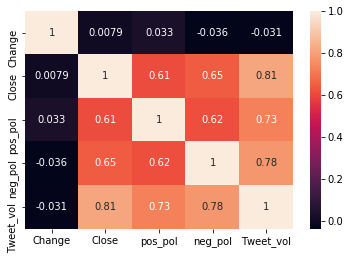

In [74]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [75]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [76]:
#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [77]:
#add lagged data to records
data_with_lagged = create_lagged_features(df_copy, n_lag, 1)
data_with_lagged = data_with_lagged.reset_index()
data_with_lagged = data_with_lagged.drop(['DateTime'], axis=1)

In [78]:
#shuffle data
np.random.seed(1)
#shuffle times 
shuffle_times = 5;
for j in range(0, shuffle_times+1):
    data_with_lagged = shuffle(data_with_lagged)

In [79]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

train = data_with_lagged.iloc[:train_size]
test = data_with_lagged.iloc[train_size:]

In [80]:
#prepare labels
train_y = train["var1(t)"].values
test_y = test["var1(t)"].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)

In [81]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)
joblib.dump(xscaler, 'saved/scaler.pkl') 

['saved/scaler.pkl']

In [82]:
#prepare data
train_labels = train_y
test_labels = test_y

In [83]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [84]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]

In [85]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

In [86]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)

In [87]:
np.random.seed(1) 
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 64
epochs = 10000
dropout = 0.25
batch_size = 80
activ_func = "linear"

model.add(Bidirectional(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(neurons, return_sequences=False, activation=activ_func)))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
# early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =50)

# fit network
history = model.fit(train_X, train_y, epochs=10000, batch_size=batch_size, verbose=2, shuffle=True,validation_split=0.2, callbacks=[callback])

Epoch 1/10000
4/4 - 4s - loss: 0.6946 - accuracy: 0.4917 - val_loss: 0.6818 - val_accuracy: 0.5526
Epoch 2/10000
4/4 - 0s - loss: 0.6875 - accuracy: 0.5415 - val_loss: 0.6810 - val_accuracy: 0.5526
Epoch 3/10000
4/4 - 0s - loss: 0.6924 - accuracy: 0.5216 - val_loss: 0.6809 - val_accuracy: 0.5658
Epoch 4/10000
4/4 - 0s - loss: 0.6891 - accuracy: 0.5382 - val_loss: 0.6798 - val_accuracy: 0.6184
Epoch 5/10000
4/4 - 0s - loss: 0.6866 - accuracy: 0.5515 - val_loss: 0.6806 - val_accuracy: 0.5526
Epoch 6/10000
4/4 - 0s - loss: 0.6891 - accuracy: 0.5216 - val_loss: 0.6785 - val_accuracy: 0.6053
Epoch 7/10000
4/4 - 0s - loss: 0.6873 - accuracy: 0.5116 - val_loss: 0.6780 - val_accuracy: 0.5921
Epoch 8/10000
4/4 - 0s - loss: 0.6857 - accuracy: 0.5548 - val_loss: 0.6789 - val_accuracy: 0.5789
Epoch 9/10000
4/4 - 0s - loss: 0.6821 - accuracy: 0.5615 - val_loss: 0.6806 - val_accuracy: 0.5526
Epoch 10/10000
4/4 - 0s - loss: 0.6859 - accuracy: 0.5449 - val_loss: 0.6764 - val_accuracy: 0.5526
Epoch 11/

In [ ]:
#save model
model.save("saved/ckpt")

In [89]:
#save model
model_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


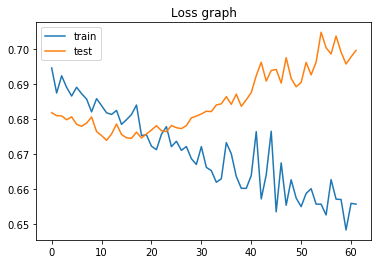

In [90]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

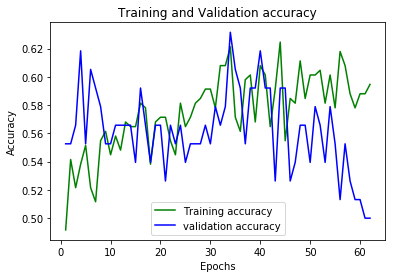

In [91]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

In [93]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [94]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.6417910447761194


In [95]:
sklearn.metrics.classification_report(test_y, pred, zero_division=0,output_dict=True)

{'0': {'precision': 0.76,
  'recall': 0.5135135135135135,
  'f1-score': 0.6129032258064517,
  'support': 37},
 '1': {'precision': 0.5714285714285714,
  'recall': 0.8,
  'f1-score': 0.6666666666666666,
  'support': 30},
 'accuracy': 0.6417910447761194,
 'macro avg': {'precision': 0.6657142857142857,
  'recall': 0.6567567567567567,
  'f1-score': 0.6397849462365592,
  'support': 67},
 'weighted avg': {'precision': 0.6755650319829425,
  'recall': 0.6417910447761194,
  'f1-score': 0.6369764082811749,
  'support': 67}}